In [1]:
import pandas as pd

# File paths for the uploaded files
train_scores_path = 'train_scores.csv'
train_logs_path = 'train_logs.csv'
sample_submission_path = 'sample_submission.csv'
test_logs_path = 'test_logs.csv'

# Loading the data into Pandas DataFrames
train_scores = pd.read_csv(train_scores_path)
train_logs = pd.read_csv(train_logs_path)
sample_submission = pd.read_csv(sample_submission_path)
test_logs = pd.read_csv(test_logs_path)

# Display the first few rows of each DataFrame to understand their structure
train_scores.head(), train_logs.head(), sample_submission.head(), test_logs.head()

(         id  score
 0  001519c8    3.5
 1  0022f953    3.5
 2  0042269b    6.0
 3  0059420b    2.0
 4  0075873a    4.0,
          id  event_id  down_time  up_time  action_time       activity  \
 0  001519c8         1       4526     4557           31  Nonproduction   
 1  001519c8         2       4558     4962          404  Nonproduction   
 2  001519c8         3     106571   106571            0  Nonproduction   
 3  001519c8         4     106686   106777           91          Input   
 4  001519c8         5     107196   107323          127          Input   
 
   down_event   up_event text_change  cursor_position  word_count  
 0  Leftclick  Leftclick    NoChange                0           0  
 1  Leftclick  Leftclick    NoChange                0           0  
 2      Shift      Shift    NoChange                0           0  
 3          q          q           q                1           1  
 4          q          q           q                2           1  ,
          id  score
 0  

In [3]:
import pandas as pd

# Load the data
train_logs_path = 'train_logs.csv'  # Replace with the actual path
train_logs = pd.read_csv(train_logs_path)

# Display the first few rows to understand its structure
print(train_logs.head())


         id  event_id  down_time  up_time  action_time       activity  \
0  001519c8         1       4526     4557           31  Nonproduction   
1  001519c8         2       4558     4962          404  Nonproduction   
2  001519c8         3     106571   106571            0  Nonproduction   
3  001519c8         4     106686   106777           91          Input   
4  001519c8         5     107196   107323          127          Input   

  down_event   up_event text_change  cursor_position  word_count  
0  Leftclick  Leftclick    NoChange                0           0  
1  Leftclick  Leftclick    NoChange                0           0  
2      Shift      Shift    NoChange                0           0  
3          q          q           q                1           1  
4          q          q           q                2           1  


In [4]:
# Grouping by user ID and aggregating data
aggregated_data = train_logs.groupby('id').agg({
    'down_time': 'sum',
    'up_time': 'sum',
    'action_time': 'mean',  # Average action time
    'event_id': 'count',    # Count of events
    'cursor_position': 'max',  # Maximum cursor position
    'word_count': 'max'    # Maximum word count
}).reset_index()

# Adding a new feature: total duration (up_time - down_time)
aggregated_data['total_duration'] = aggregated_data['up_time'] - aggregated_data['down_time']

# Display the first few rows of the aggregated data
print(aggregated_data.head())


         id   down_time     up_time  action_time  event_id  cursor_position  \
0  001519c8  2168798234  2169095477   116.246774      2557             1539   
1  0022f953  1273271023  1273546414   112.221271      2454             1676   
2  0042269b  3426641982  3427063183   101.837766      4136             2291   
3  0059420b  1222211589  1222401185   121.848329      1556             1047   
4  0075873a  1805499474  1805813176   123.943896      2531             1402   

   word_count  total_duration  
0         256          297243  
1         323          275391  
2         404          421201  
3         206          189596  
4         252          313702  


In [6]:
# Ensure that 'id' is the index for aggregated data
aggregated_data.set_index('id', inplace=True)

# Recalculate the additional features with 'id' as the index
activity_counts = pd.get_dummies(train_logs['activity']).groupby(train_logs['id']).sum()
space_down_event = (train_logs['down_event'] == 'Space').astype(int).groupby(train_logs['id']).sum()
space_up_event = (train_logs['up_event'] == 'Space').astype(int).groupby(train_logs['id']).sum()
text_changes = (train_logs['text_change'] != 'NoChange').astype(int).groupby(train_logs['id']).sum()

# Merging these features with the aggregated data
extended_features = pd.concat([aggregated_data, activity_counts, space_down_event, space_up_event, text_changes], axis=1)

# Renaming the new columns for clarity
extended_features.rename(columns={0: 'space_down_events', 1: 'space_up_events', 2: 'text_changes'}, inplace=True)

# Resetting index for convenience
extended_features.reset_index(inplace=True)

# Display the first few rows of the extended dataset
print(extended_features.head())


         id   down_time     up_time  action_time  event_id  cursor_position  \
0  001519c8  2168798234  2169095477   116.246774      2557             1539   
1  0022f953  1273271023  1273546414   112.221271      2454             1676   
2  0042269b  3426641982  3427063183   101.837766      4136             2291   
3  0059420b  1222211589  1222401185   121.848329      1556             1047   
4  0075873a  1805499474  1805813176   123.943896      2531             1402   

   word_count  total_duration  Input  Move From [0, 158] To [234, 392]  ...  \
0         256          297243   2010                                 0  ...   
1         323          275391   1938                                 0  ...   
2         404          421201   3515                                 0  ...   
3         206          189596   1304                                 0  ...   
4         252          313702   1942                                 0  ...   

   Move From [923, 1077] To [340, 494]  Move From 

In [7]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(extended_features, test_size=0.20, random_state=42)

# Output the size of the training and testing datasets
print("Training Set Size:", train_set.shape)
print("Testing Set Size:", test_set.shape)


Training Set Size: (1976, 61)
Testing Set Size: (495, 61)


In [8]:
# Summary Statistics
print(train_set.describe())


          down_time       up_time  action_time      event_id  cursor_position  \
count  1.976000e+03  1.976000e+03  1976.000000   1976.000000      1976.000000   
mean   2.723741e+09  2.724075e+09    99.960906   3410.969130      2236.889170   
std    1.782005e+09  1.782117e+09    24.580941   1604.027846       970.986165   
min    1.723896e+07  1.725651e+07    14.131749    262.000000       207.000000   
25%    1.567100e+09  1.567313e+09    83.416385   2192.750000      1491.000000   
50%    2.334999e+09  2.335309e+09    96.805660   3101.000000      2006.000000   
75%    3.440922e+09  3.441403e+09   114.573862   4282.000000      2764.000000   
max    2.424430e+10  2.424494e+10   282.612447  12876.000000      7802.000000   

        word_count  total_duration        Input  \
count  1976.000000    1.976000e+03  1976.000000   
mean    390.882085    3.337112e+05  2723.941802   
std     172.109688    1.571591e+05  1201.373838   
min      35.000000    1.754100e+04   230.000000   
25%     255.750

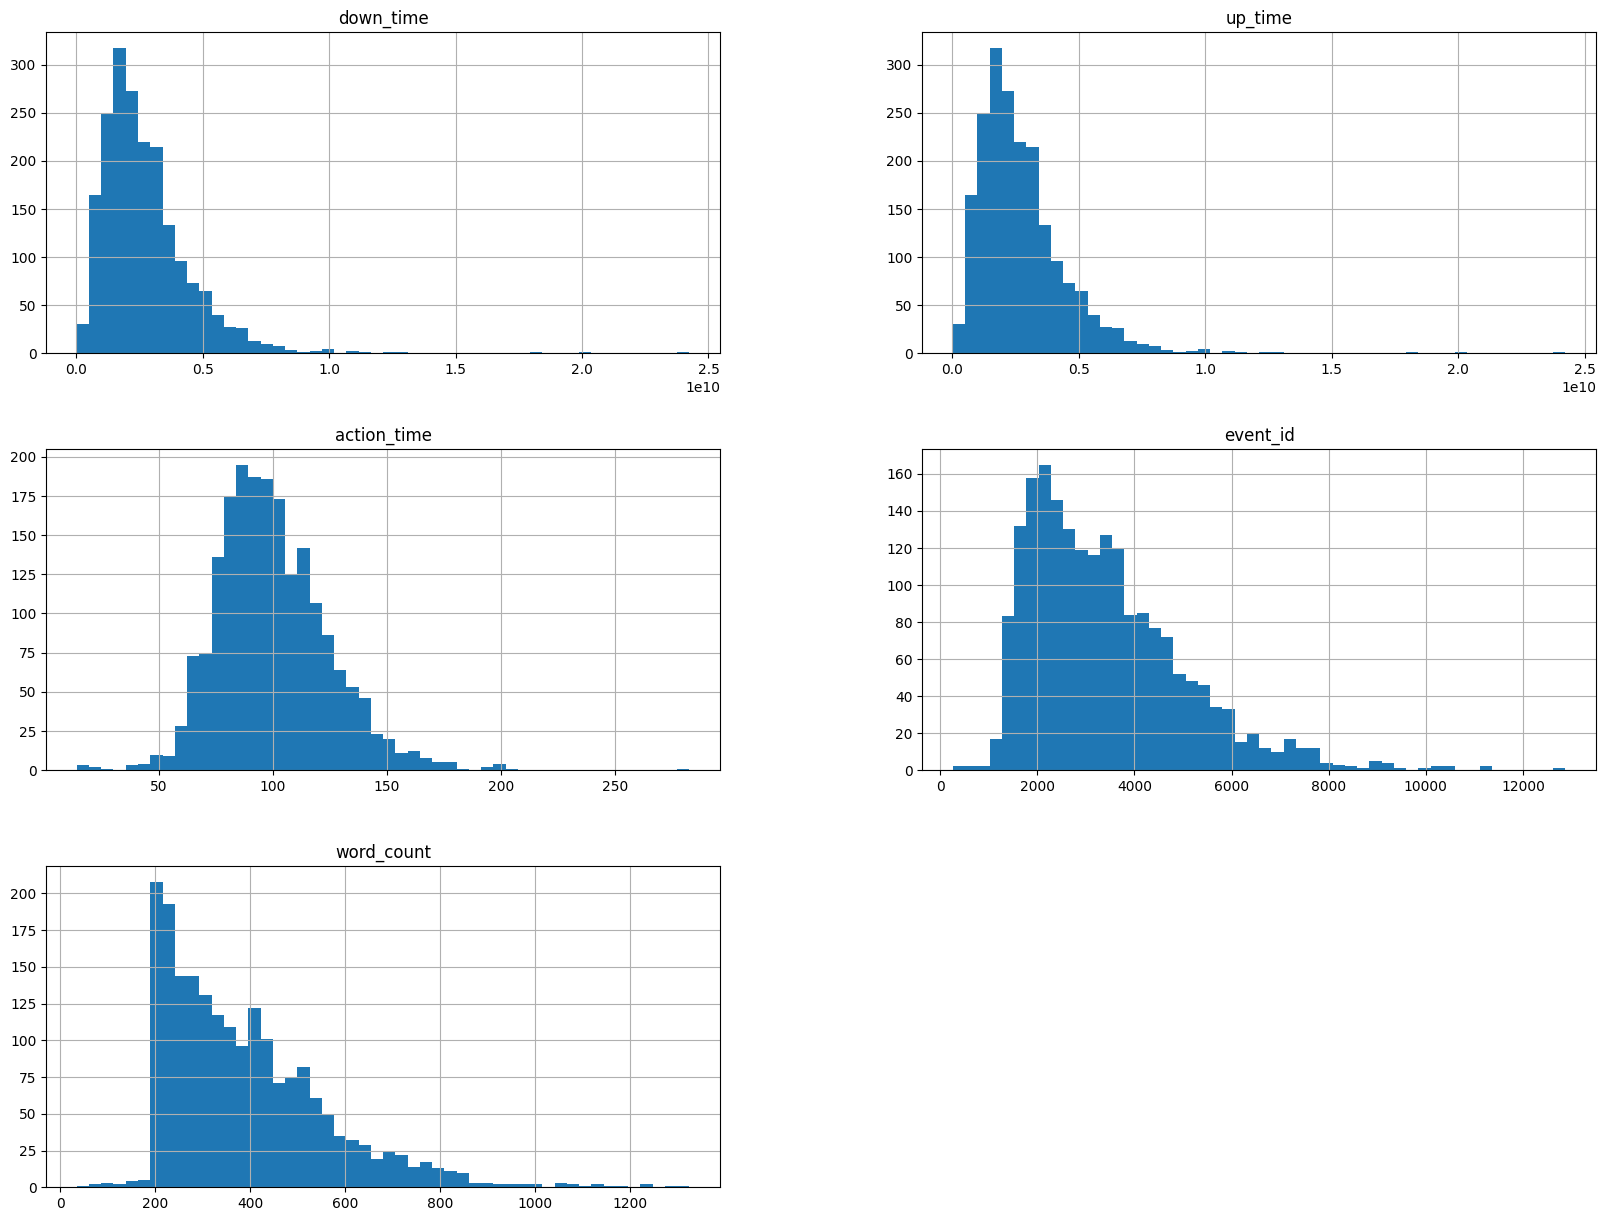

In [9]:
import matplotlib.pyplot as plt

# Histograms for a selection of features
train_set[['down_time', 'up_time', 'action_time', 'event_id', 'word_count']].hist(bins=50, figsize=(20,15))
plt.show()


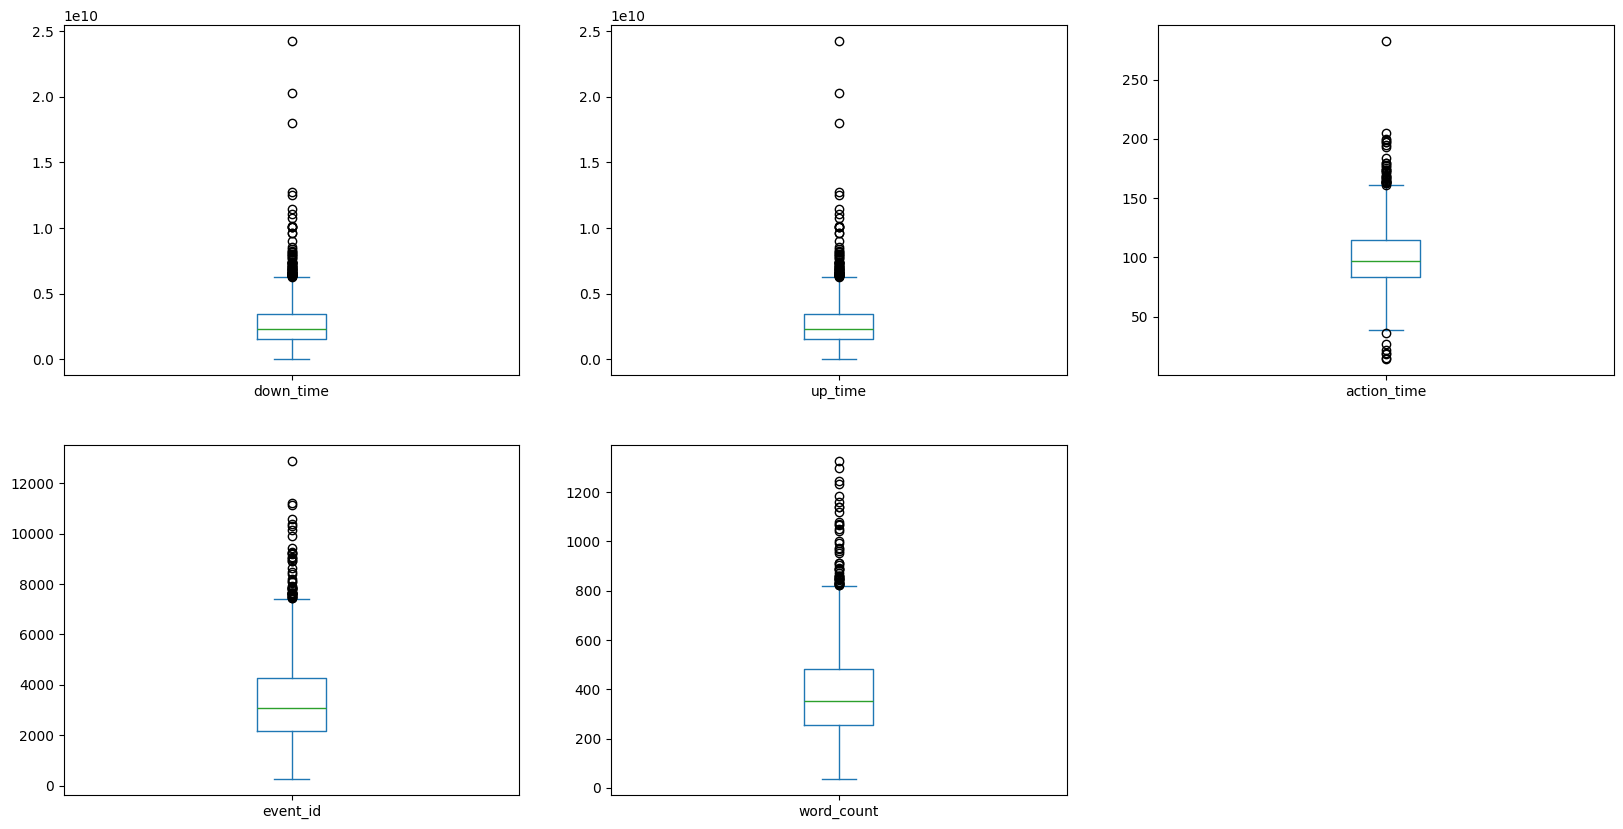

In [10]:
# Box plots for the same selection of features
train_set[['down_time', 'up_time', 'action_time', 'event_id', 'word_count']].plot(kind='box', subplots=True, layout=(2,3), figsize=(20,10))
plt.show()
